# Task 1 : Set up colab gpu runtime environment

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

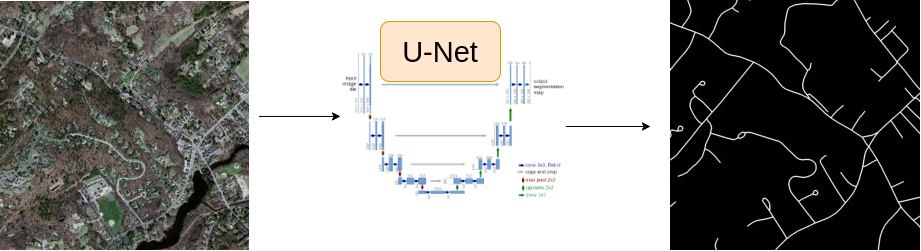

# Download Subset Dataset

In [1]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

fatal: destination path 'Road_seg_dataset' already exists and is not an empty directory.


# Some Common Imports

In [2]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [8]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [4]:

# File paths
CSV_FILE = '/home/tom/Python/Machine learning/pytorch/image segmentation/Road_seg_dataset/train.csv'
DATA_DIR = '/home/tom/Python/Machine learning/pytorch/image segmentation/Road_seg_dataset/'

# Device settings
DEVICE = 'cuda'

# Model parameters
BATCH_SIZE = 8
IMG_SIZE = 512
LR = 0.003
EPOCHS = 25
ENCODER= 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'



In [5]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [6]:
idx = 2
row = df.iloc[idx]
image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

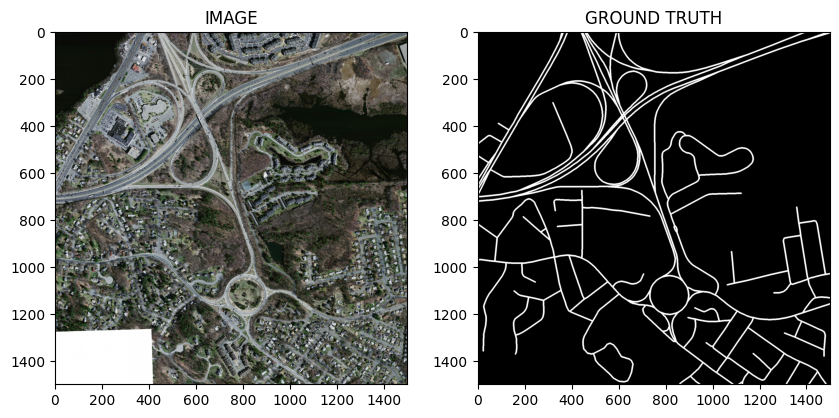

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [8]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [9]:
import albumentations as A

In [10]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ])

# Task 4 : Create Custom Dataset

In [11]:
from torch.utils.data import Dataset

In [12]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = df.iloc[idx]

        image_path = DATA_DIR + row.images
        mask_path = DATA_DIR + row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # (h, W, C)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w)
        mask = np.expand_dims(mask, axis=-1)  # (h, W, c) # added additional dimenion for channel. channel =1 as its grayscale

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image, mask = data['image'], data['mask']

        # Transpose and normalize
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # (C, h, w) # now channel at 0th axis, height at 1st axis and width on 3rd axis
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)  # (c, h, w)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [13]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [14]:
print(f'Size of trainset: {len(trainset)}')
print(f'Size of validset: {len(validset)}')

Size of trainset: 159
Size of validset: 40


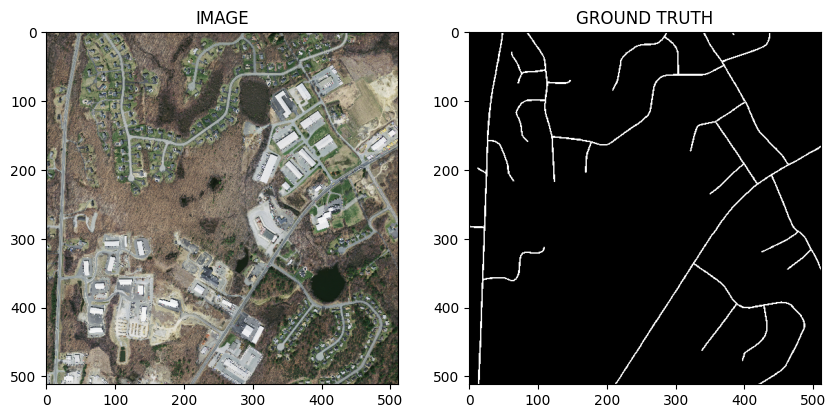

In [15]:
idx = 69
image, mask = trainset[idx]


helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [33]:
from torch.utils.data import DataLoader

In [34]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [35]:
print(f'Total no. of batches in trainloader: {len(trainloader)}')
print(f'Total no. of batches in validloader: {len(validloader)}')

Total no. of batches in trainloader: 20
Total no. of batches in validloader: 5


In [36]:
for images, masks in trainloader:
    print(f"One batch image shape: {images.shape}")
    print(f"One batch mask shape: {masks.shape}")
    break

One batch image shape: torch.Size([8, 3, 512, 512])
One batch mask shape: torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [9]:
import torch.nn as nn
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.losses as DiceLoss

In [38]:

class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.backbone = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.backbone(images)

        if masks is not None:
            return logits, masks

        return logits


In [10]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # maxpooling layer divides input size by two
        )

        # Centerzz
        self.center = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  #maxpooling layer divides input size by two. as this is the second layer of maxppoling. the input size is now one by forth
        )

        # Decoderz
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2) # In this layer , the input is upsampled by two. 
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder(x)
        # Center
        center = self.center(enc1)
        # Decoder
        dec1 = self.decoder(center)

        return dec1


In [40]:
#model = SegmentationModel()

In [41]:
in_channels = 3  # Number of input channels (e.g., for RGB images)
out_channels = 1  # Number of output channels (1 for binary segmentation)
model = UNet(in_channels, out_channels)
model.to(DEVICE)

UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (center): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)

# Task 7 : Create Train and Validation Function

In [42]:
import torch.nn.functional as F

In [43]:
def train_fn(dataloader, model, optimizer):
    model.train()  # Turn ON dropout, batchnorm, etc..
    total_loss = 0.0

    for images, masks in tqdm(dataloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits = model(images) 
        logits = F.interpolate(logits, size=(512, 512), mode='bilinear', align_corners=False)
        if masks is not None:
            bce_loss = nn.BCEWithLogitsLoss()
            loss=bce_loss(logits, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)  

In [44]:
def eval_fn(dataloader, model):
    model.eval()  # Turn OFF dropout, batchnorm, etc..
    total_loss = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
    
            optimizer.zero_grad()
            logits = model(images) 
            logits = F.interpolate(logits, size=(512, 512), mode='bilinear', align_corners=False)
            if masks is not None:
                bce_loss = nn.BCEWithLogitsLoss()
                loss=bce_loss(logits, masks)
    
            total_loss += loss.item()
    
        return total_loss / len(dataloader)  

# Task 8 : Train Model

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [46]:

best_loss = np.Inf

for epoch in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_loss:
        torch.save(model.state_dict(), "best-model.pt")
        print("SAVED-MODEL")
        best_loss = valid_loss

    print(f'Epoch: {epoch + 1}, Train Loss: {train_loss}, Valid Loss: {valid_loss}')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]


SAVED-MODEL
Epoch: 1, Train Loss: 0.48327397108078, Valid Loss: 0.35889623165130613


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]


SAVED-MODEL
Epoch: 2, Train Loss: 0.24669312238693236, Valid Loss: 0.23275043964385986


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]


SAVED-MODEL
Epoch: 3, Train Loss: 0.20835481509566306, Valid Loss: 0.22464711368083953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43it/s]


SAVED-MODEL
Epoch: 4, Train Loss: 0.20367764830589294, Valid Loss: 0.21851280927658082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch: 5, Train Loss: 0.20087427794933319, Valid Loss: 0.22050793170928956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]


SAVED-MODEL
Epoch: 6, Train Loss: 0.1971060261130333, Valid Loss: 0.20951762199401855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.47it/s]


SAVED-MODEL
Epoch: 7, Train Loss: 0.19615956395864487, Valid Loss: 0.20655060410499573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch: 8, Train Loss: 0.19040603563189507, Valid Loss: 0.2073173701763153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch: 9, Train Loss: 0.19167151898145676, Valid Loss: 0.20781266689300537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.41it/s]


SAVED-MODEL
Epoch: 10, Train Loss: 0.18813996240496636, Valid Loss: 0.204120734333992


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch: 11, Train Loss: 0.19014371633529664, Valid Loss: 0.2053416043519974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]


SAVED-MODEL
Epoch: 12, Train Loss: 0.18779893815517426, Valid Loss: 0.20144069492816924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch: 13, Train Loss: 0.18737021125853062, Valid Loss: 0.2022571325302124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch: 14, Train Loss: 0.18488347195088864, Valid Loss: 0.20170795023441315


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]


SAVED-MODEL
Epoch: 15, Train Loss: 0.18443335965275764, Valid Loss: 0.19863519668579102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch: 16, Train Loss: 0.18099244460463523, Valid Loss: 0.20141912400722503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


SAVED-MODEL
Epoch: 17, Train Loss: 0.1827571712434292, Valid Loss: 0.19293901920318604


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]


SAVED-MODEL
Epoch: 18, Train Loss: 0.17745572477579116, Valid Loss: 0.1929250419139862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]


SAVED-MODEL
Epoch: 19, Train Loss: 0.17576400563120842, Valid Loss: 0.18872639834880828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43it/s]


SAVED-MODEL
Epoch: 20, Train Loss: 0.1717094250023365, Valid Loss: 0.18544136583805085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.41it/s]


SAVED-MODEL
Epoch: 21, Train Loss: 0.1745052754878998, Valid Loss: 0.1832343429327011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch: 22, Train Loss: 0.16846893802285196, Valid Loss: 0.1851073384284973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


SAVED-MODEL
Epoch: 23, Train Loss: 0.16472113281488418, Valid Loss: 0.1755709856748581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.21it/s]


SAVED-MODEL
Epoch: 24, Train Loss: 0.16194800548255445, Valid Loss: 0.17212520241737367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43it/s]

Epoch: 25, Train Loss: 0.160564848780632, Valid Loss: 0.17614908814430236


# Task 9 : Inference

In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

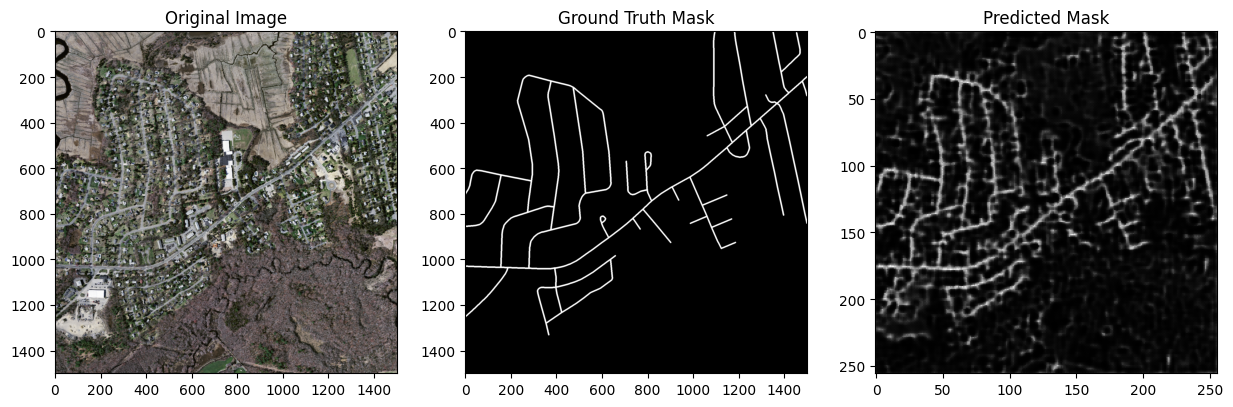

In [16]:


# Assuming you have a testing dataset named testloader
# Define your test data loader accordingly

# Load the trained model
model = UNet(3, 1)
model.load_state_dict(torch.load("best-model.pt"))
model.to(DEVICE)
model.eval()

# Define a function to apply the model to an input image
def predict_image(image_path, model):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([transforms.Resize((512, 512)),
                                    transforms.ToTensor()])
    image = transform(image).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        model_output = model(image)
        predicted_mask = F.sigmoid(model_output)

    return predicted_mask.squeeze().cpu().numpy()

# Choose an image from your test set
test_image_path = "/home/tom/Python/Machine learning/pytorch/image segmentation/Road_seg_dataset/images/26728720_15.png"

# Get the predicted mask
predicted_mask = predict_image(test_image_path, model)

# Display the original image, ground truth mask, and predicted mask
original_image = Image.open(test_image_path).convert('RGB')
ground_truth_mask = Image.open("/home/tom/Python/Machine learning/pytorch/image segmentation/Road_seg_dataset/masks/26728720_15.png").convert('L')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original_image)
axes[0].set_title("Original Image")

axes[1].imshow(ground_truth_mask, cmap='gray')
axes[1].set_title("Ground Truth Mask")

axes[2].imshow(predicted_mask, cmap='gray')
axes[2].set_title("Predicted Mask")

plt.show()
